In [1]:
import os
from abc import abstractmethod, ABC
from dataclasses import dataclass

import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.ticker import FuncFormatter

from QHyper.problems.algorithms.workflow_decomposition import SeriesParallelSplitFinal
from QHyper.problems.workflow_scheduling import WorkflowSchedulingOneHot, Workflow

In [2]:
class ExperimentResult(ABC):
    pass

@dataclass
class Comparison:
    relative_max_subgraph_size: float
    divided_problems: list[WorkflowSchedulingOneHot]
    reference_problem: WorkflowSchedulingOneHot


class Experiment(ABC):
    def __init__(self, tasks_file, machines_file, deadline):
        self.tasks_file = tasks_file
        self.machines_file = machines_file
        self.deadline = deadline

    def _get_divided_problems(self, max_graph_size: int) -> list[WorkflowSchedulingOneHot]:
        workflow = Workflow(self.tasks_file, self.machines_file, self.deadline)
        division = SeriesParallelSplitFinal().decompose(workflow, max_graph_size)
        return [WorkflowSchedulingOneHot(w) for w in division.workflows]

    def _get_problem(self) -> WorkflowSchedulingOneHot:
        return WorkflowSchedulingOneHot(Workflow(self.tasks_file, self.machines_file, self.deadline))

    def _compare(self, relative_max_subgraph_size: float, max_subgraph_size: int) -> Comparison:
        return Comparison(
            relative_max_subgraph_size,
            self._get_divided_problems(max_subgraph_size),
            self._get_problem()
        )

    @abstractmethod
    def run(self) -> ExperimentResult:
        pass

In [3]:
class ProblemSizeIncreaseExperiment(Experiment):
    def __init__(self, tasks_file, machines_file, relative_max_subgraph_sizes: list[float]):
        super().__init__(tasks_file, machines_file, 1000000)
        self.relative_max_subgraph_sizes: list[float] = relative_max_subgraph_sizes
        self.max_subgraph_sizes_map: dict[float, int] = self._get_max_subgrah_sizes()

    def _get_max_subgrah_sizes(self):
        n_tasks: int = len(Workflow(self.tasks_file, self.machines_file, self.deadline).tasks)
        max_subgraph_sizes = [int(multiplier * n_tasks) for multiplier in self.relative_max_subgraph_sizes]
        return {relative: mss for relative, mss in zip(self.relative_max_subgraph_sizes, max_subgraph_sizes) if
                mss >= 2}

    class ProblemSizeIncreaseExperimentResult(ExperimentResult):
        def __init__(self, comparisons: list[Comparison]):
            self.comparisons = comparisons
            self.influences = self._calculate_influences(comparisons)

        @staticmethod
        def _calculate_influences(comparisons: list[Comparison]):
            def get_record(comparison: Comparison):
                max_path_count = max([len(p.workflow.paths) for p in comparison.divided_problems])
                max_variable_count = max([len(p.variables) for p in comparison.divided_problems])
                max_constraint_count = max([len(p.constraints) for p in comparison.divided_problems])
                return {
                    'workflow_size': len(comparison.reference_problem.workflow.tasks),
                    'mss': comparison.relative_max_subgraph_size,
                    'path_increase': max_path_count / len(comparison.reference_problem.workflow.paths),
                    'variable_increase': max_variable_count / len(comparison.reference_problem.variables),
                    'constraint_increase': max_constraint_count / len(comparison.reference_problem.constraints)
                }

            return pd.DataFrame(data=[get_record(c) for c in comparisons])

    def run(self) -> ProblemSizeIncreaseExperimentResult:
        return self.ProblemSizeIncreaseExperimentResult(
            [self._compare(r_mss, mss) for r_mss, mss in self.max_subgraph_sizes_map.items()])

In [4]:
def run_for_family(workflows: list[str], machines_file: str, divisions: list[float], csv_save_path: str):
    result: pd.DataFrame = pd.concat([ProblemSizeIncreaseExperiment(t, machines_file, divisions).run().influences for t in workflows], axis=0)
    if csv_save_path:
        result.to_csv(csv_save_path, index=False)

In [15]:
def plot_for_family(family_increases: pd.DataFrame, family: str, save_path: str = None):
    fig, axs = plt.subplots(1, 2, figsize=(18,8))
    
    for size, data in family_increases.groupby('workflow_size'):
        data = data[data['mss'] < 1]
        data['mss'] = (data['mss'] * 100).astype(int)
        data['constraint_increase'] = (data['constraint_increase'] * 100)
        data['variable_increase'] = (data['variable_increase'] * 100)
        axs[0].plot(data['mss'], data['constraint_increase'], 'o-', linewidth=2, label=f'{size} nodes')
        axs[1].plot(data['mss'], data['variable_increase'], 'o-', linewidth=2, label=f'{size} nodes')
        axs[0].set_xticks(data['mss'])
        axs[1].set_xticks(data['mss'])
        axs[0].set_xticklabels(axs[0].get_xticks(), fontsize=18)
        axs[0].set_yticklabels(axs[0].get_yticks(), fontsize=18)
        axs[1].set_xticklabels(axs[1].get_xticks(), fontsize=18)
        axs[1].set_yticklabels(axs[1].get_yticks(), fontsize=18)
        axs[0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{int(y)}'))
        axs[1].yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{int(y)}'))
    
    # ax.set_xticks([int(division * 100) for division in divisions])
    # ax.set_xticklabels(ax.get_xticks(), fontsize=12)
    # ax.set_yticklabels(ax.get_yticks(), fontsize=12)
    # ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.2f}'))
    axs[0].set_xlabel('Max subgraph size relative to workflow size [%]', fontsize=20)
    axs[0].set_ylabel('Constraints count change [%]', fontsize=20)
    axs[0].legend(fontsize=20)
    
    axs[1].set_xlabel('Max subgraph size relative to workflow size [%]', fontsize=20)
    axs[1].set_ylabel('Variables count change [%]', fontsize=20)
    axs[1].legend(fontsize=20)
    
    # plt.legend(fontsize=16)
    # plt.suptitle(f'Influence of the max subgraph size on the problem size for {family} workflows', fontsize=20)
    plt.show()
    
    if save_path:
        fig.savefig(save_path, bbox_inches='tight')

In [6]:
machines_file = "../workflows_data/machines/single_machine.json"
divisions = [1.5, 0.75, 0.5, 0.25, 0.15, 0.1, 0.05, 0.01]

# 1000genome

In [9]:
workflows = [
    "/home/marcin/Programming/pegasus-instances/1000genome/chameleon-cloud/1000genome-chameleon-6ch-100k-001.json",
    "/home/marcin/Programming/pegasus-instances/1000genome/chameleon-cloud/1000genome-chameleon-12ch-250k-001.json",
    "/home/marcin/Programming/pegasus-instances/1000genome/chameleon-cloud/1000genome-chameleon-22ch-250k-001.json"
]
csv_file = os.path.join("problem_size_increase", "1000genome.csv")
png_file = os.path.join("problem_size_increase", "1000genome.png")

In [10]:
run_for_family(workflows, machines_file, divisions, csv_file)

/tmp/ipykernel_57646/3428396769.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['mss'] = (data['mss'] * 100).astype(int)
/tmp/ipykernel_57646/3428396769.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['constraint_increase'] = (data['constraint_increase'] * 100)
/tmp/ipykernel_57646/3428396769.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:/

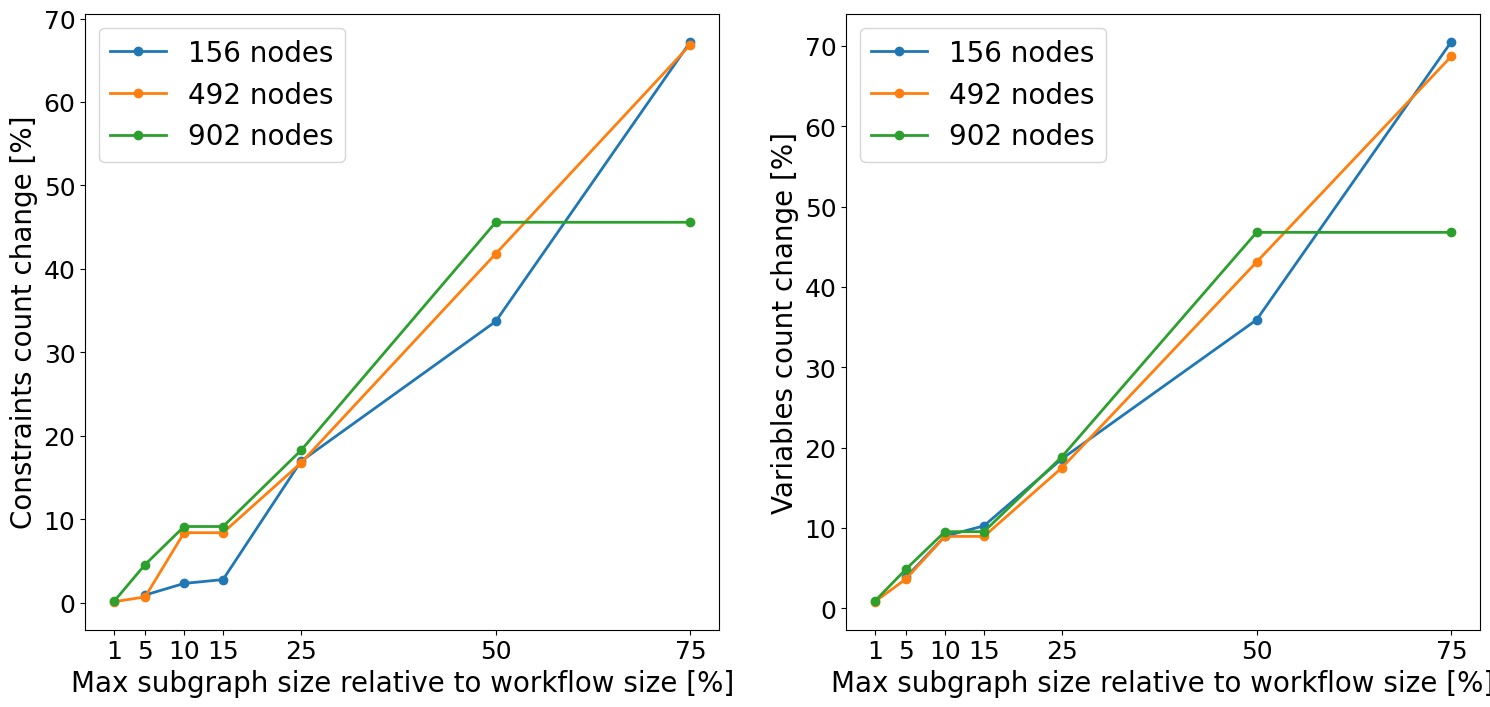

In [16]:
plot_for_family(pd.read_csv(csv_file), "1000genome", png_file)

# Epigenomics

In [17]:
workflows = [
    "/home/marcin/Programming/pegasus-instances/epigenomics/chameleon-cloud/epigenomics-chameleon-hep-1seq-100k-001.json",
    "/home/marcin/Programming/pegasus-instances/epigenomics/chameleon-cloud/epigenomics-chameleon-hep-6seq-50k-001.json",
    "/home/marcin/Programming/pegasus-instances/epigenomics/chameleon-cloud/epigenomics-chameleon-hep-3seq-100k-001.json"
]
csv_file = os.path.join("problem_size_increase", "epigenomics.csv")
png_file = os.path.join("problem_size_increase", "epigenomics.png")

In [12]:
run_for_family(workflows, machines_file, divisions, os.path.join("problem_size_increase", "epigenomics.csv"))

/tmp/ipykernel_57646/3428396769.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['mss'] = (data['mss'] * 100).astype(int)
/tmp/ipykernel_57646/3428396769.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['constraint_increase'] = (data['constraint_increase'] * 100)
/tmp/ipykernel_57646/3428396769.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:/

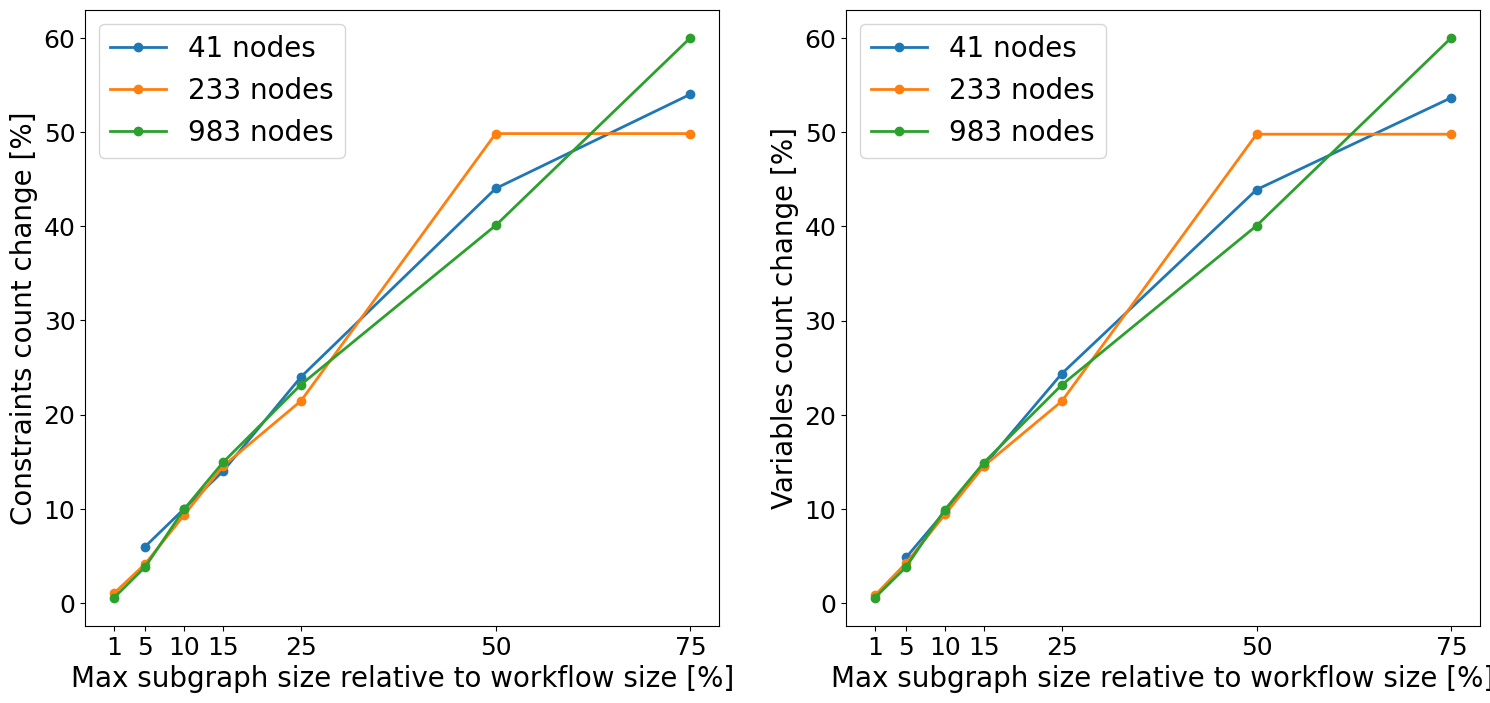

In [18]:
plot_for_family(pd.read_csv(csv_file), "Epigenomics", png_file)

# Cycles

In [19]:
workflows = [
    "/home/marcin/Programming/pegasus-instances/cycles/chameleon-cloud/cycles-chameleon-1l-2c-9p-001.json",
    "/home/marcin/Programming/pegasus-instances/cycles/chameleon-cloud/cycles-chameleon-10l-1c-9p-001.json",
    "/home/marcin/Programming/pegasus-instances/cycles/chameleon-cloud/cycles-chameleon-5l-1c-12p-001.json"
]

csv_file = os.path.join("problem_size_increase", "cycles.csv")
png_file = os.path.join("problem_size_increase", "cycles.png")

In [22]:
run_for_family(workflows, machines_file, divisions, csv_file)

/tmp/ipykernel_57646/3428396769.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['mss'] = (data['mss'] * 100).astype(int)
/tmp/ipykernel_57646/3428396769.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['constraint_increase'] = (data['constraint_increase'] * 100)
/tmp/ipykernel_57646/3428396769.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:/

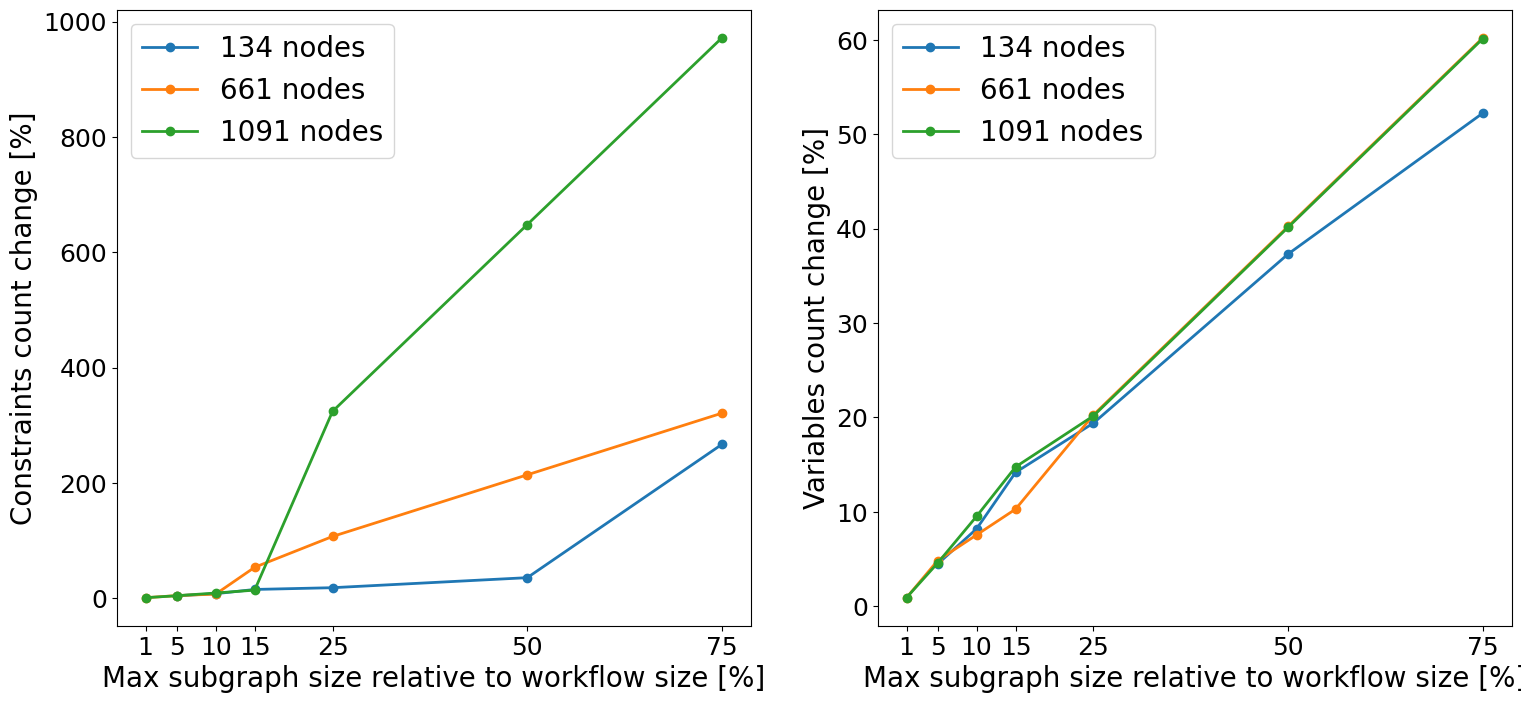

In [20]:
plot_for_family(pd.read_csv(csv_file), "Cycles", save_path=png_file)

# Montage

In [21]:
workflows = [
    "/home/marcin/Programming/pegasus-instances/montage/chameleon-cloud/montage-chameleon-dss-075d-001.json",
    "/home/marcin/Programming/pegasus-instances/montage/chameleon-cloud/montage-chameleon-dss-10d-001.json",
    "/home/marcin/Programming/pegasus-instances/montage/chameleon-cloud/montage-chameleon-dss-125d-001.json"
]

csv_file = os.path.join("problem_size_increase", "montage.csv")
png_file = os.path.join("problem_size_increase", "montage.png")

In [25]:
run_for_family(workflows, machines_file, divisions, csv_file)

/tmp/ipykernel_57646/3428396769.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['mss'] = (data['mss'] * 100).astype(int)
/tmp/ipykernel_57646/3428396769.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['constraint_increase'] = (data['constraint_increase'] * 100)
/tmp/ipykernel_57646/3428396769.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:/

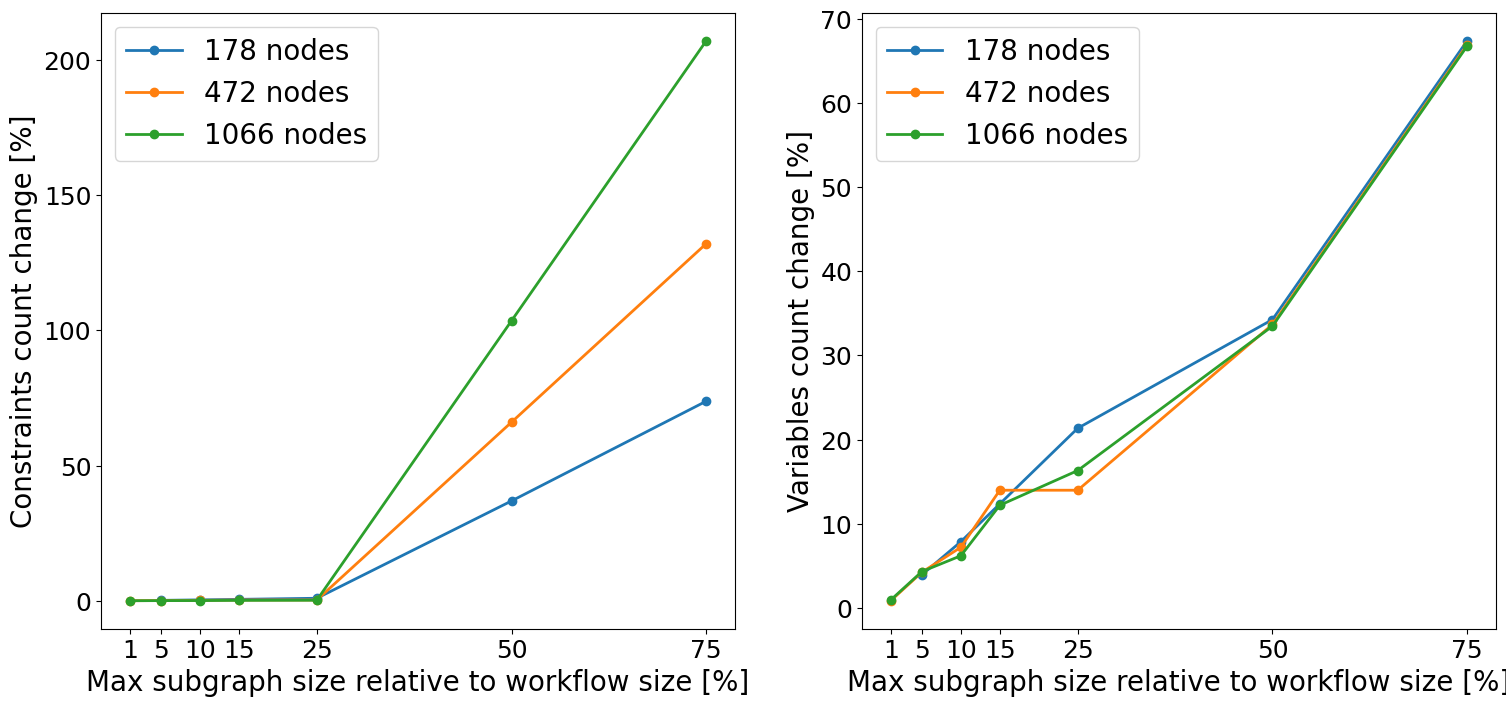

In [22]:
plot_for_family(pd.read_csv(csv_file), "Montage", save_path=png_file)

# Seismology

In [136]:
workflows = [
    "/home/marcin/Programming/pegasus-instances/seismology/chameleon-cloud/seismology-chameleon-200p-001.json",
    "/home/marcin/Programming/pegasus-instances/seismology/chameleon-cloud/seismology-chameleon-500p-001.json",
    "/home/marcin/Programming/pegasus-instances/seismology/chameleon-cloud/seismology-chameleon-1100p-001.json"
]

csv_file = os.path.join("problem_size_increase", "seismology.csv")
png_file = os.path.join("problem_size_increase", "seismology.png")

In [28]:
run_for_family(workflows, machines_file, divisions, csv_file)

/tmp/ipykernel_22735/3950454099.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['mss'] = (data['mss'] * 100).astype(int)
/tmp/ipykernel_22735/3950454099.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_yticklabels(axs[0].get_yticks(), fontsize=16)
/tmp/ipykernel_22735/3950454099.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_yticklabels(axs[1].get_yticks(), fontsize=16)
/tmp/ipykernel_22735/3950454099.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

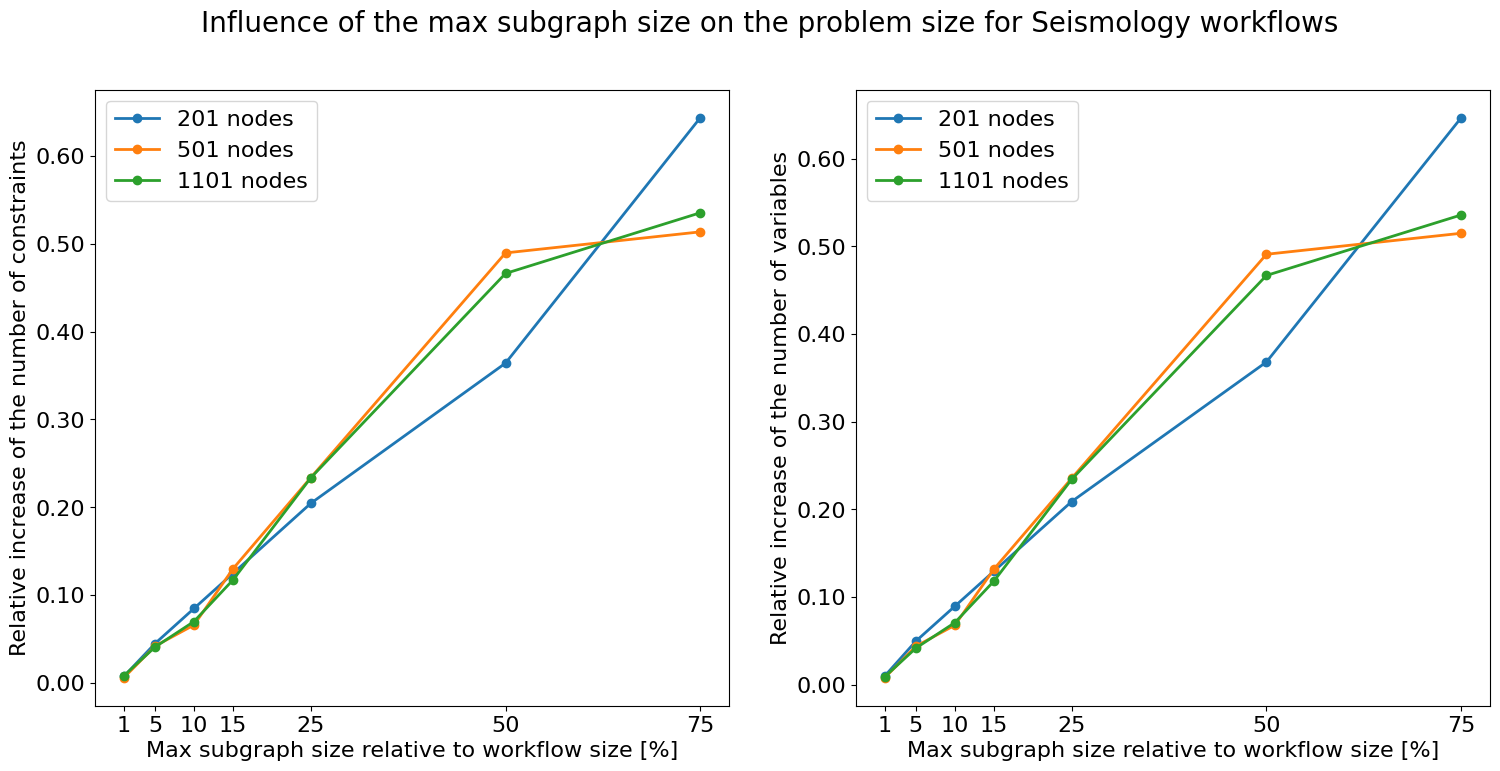

In [137]:
plot_for_family(pd.read_csv(csv_file), "Seismology", save_path=png_file)

# Soykb

In [138]:
workflows = [
    "/home/marcin/Programming/pegasus-instances/soykb/chameleon-cloud/soykb-chameleon-10fastq-20ch-001.json",
    "/home/marcin/Programming/pegasus-instances/soykb/chameleon-cloud/soykb-chameleon-50fastq-10ch-001.json",
    "/home/marcin/Programming/pegasus-instances/soykb/chameleon-cloud/soykb-chameleon-50fastq-20ch-001.json"
]

csv_file = os.path.join("problem_size_increase", "soykb.csv")
png_file = os.path.join("problem_size_increase", "soykb.png")

In [31]:
run_for_family(workflows, machines_file, divisions, csv_file)

/tmp/ipykernel_22735/3950454099.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['mss'] = (data['mss'] * 100).astype(int)
/tmp/ipykernel_22735/3950454099.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_yticklabels(axs[0].get_yticks(), fontsize=16)
/tmp/ipykernel_22735/3950454099.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_yticklabels(axs[1].get_yticks(), fontsize=16)
/tmp/ipykernel_22735/3950454099.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

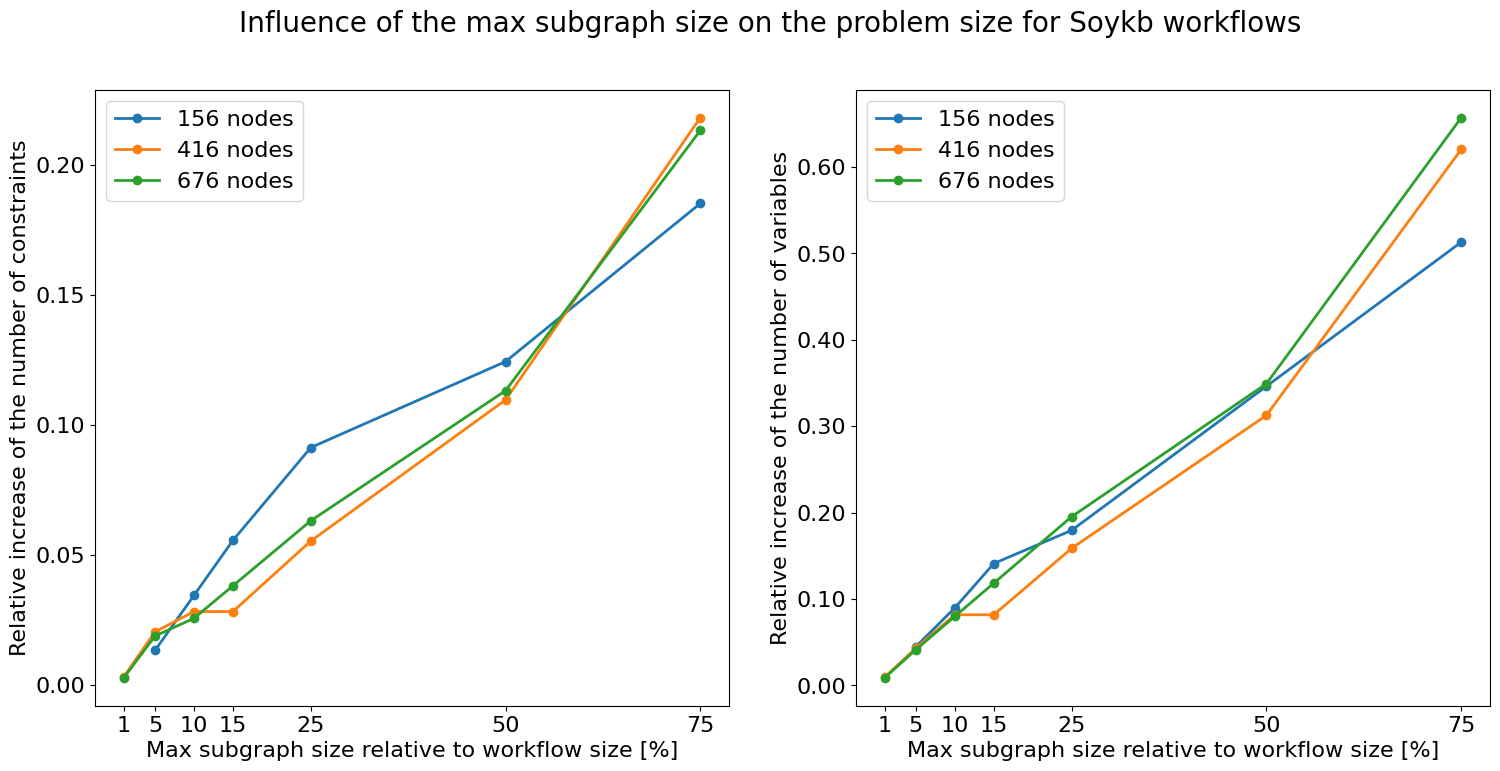

In [139]:
plot_for_family(pd.read_csv(csv_file), "Soykb", save_path=png_file)

# SraSearch

In [140]:
workflows = [
    "/home/marcin/Programming/pegasus-instances/srasearch/chameleon-cloud/srasearch-chameleon-30a-001.json",
    "/home/marcin/Programming/pegasus-instances/srasearch/chameleon-cloud/srasearch-chameleon-40a-001.json",
    "/home/marcin/Programming/pegasus-instances/srasearch/chameleon-cloud/srasearch-chameleon-50a-001.json"
]

csv_file = os.path.join("problem_size_increase", "srasearch.csv")
png_file = os.path.join("problem_size_increase", "srasearch.png")

In [34]:
run_for_family(workflows, machines_file, divisions, csv_file)

/tmp/ipykernel_22735/3950454099.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['mss'] = (data['mss'] * 100).astype(int)
/tmp/ipykernel_22735/3950454099.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_yticklabels(axs[0].get_yticks(), fontsize=16)
/tmp/ipykernel_22735/3950454099.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_yticklabels(axs[1].get_yticks(), fontsize=16)
/tmp/ipykernel_22735/3950454099.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

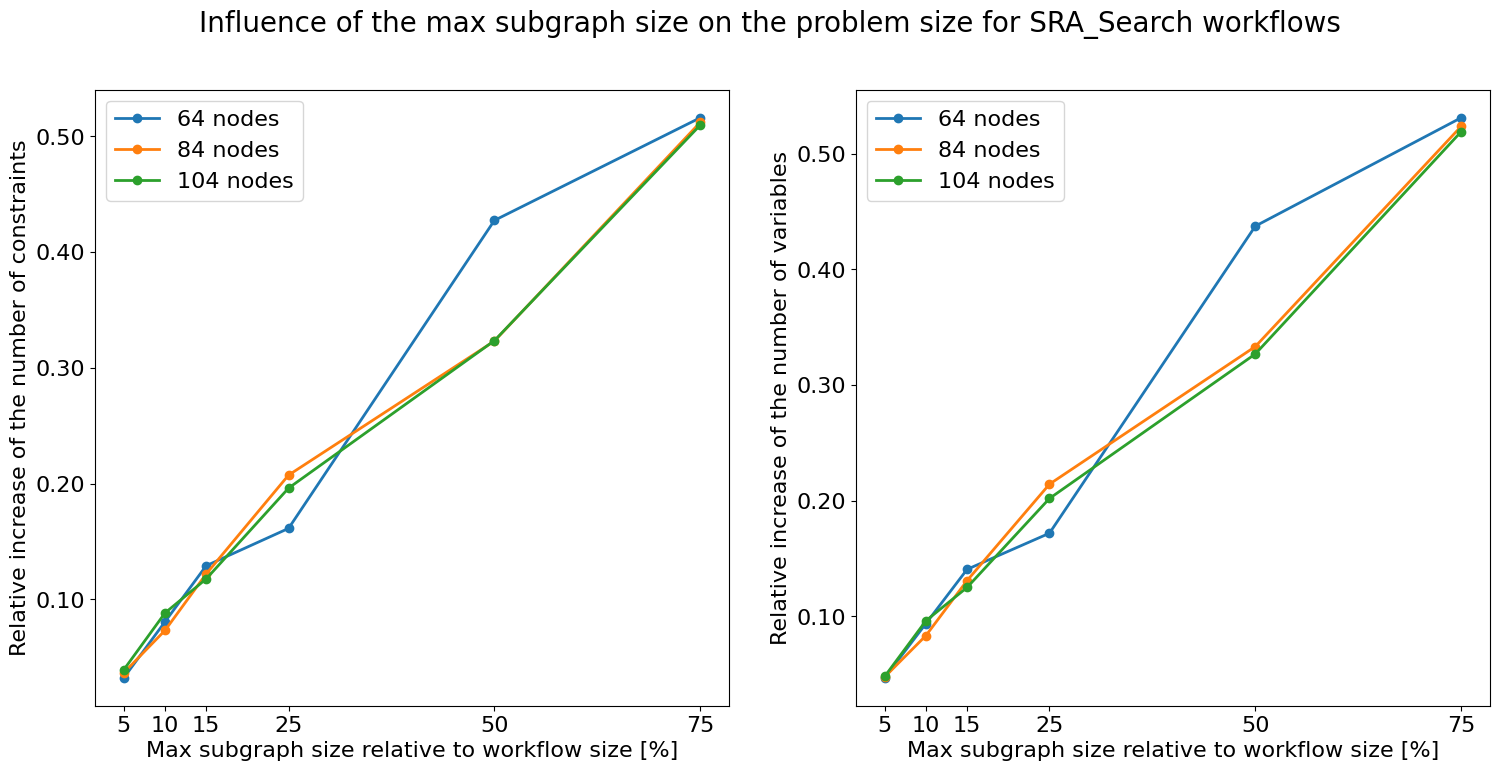

In [141]:
plot_for_family(pd.read_csv(csv_file), "SRA_Search", save_path=png_file)

# Increase caused by TTSP mapping

In [26]:
def plot_ttsp_increase(family_increases: pd.DataFrame, family: str, save_path: str = None):
    fig, ax = plt.subplots(1, 1, figsize=(6,8))
    
    sizes = []
    path_increases = []
    
    for size, data in family_increases.groupby('workflow_size'):
        data = data[data['mss'] > 1]
        sizes.append(size)
        path_increases.append(data['path_increase'].iloc[0] * 100)
    
    ax.bar(sizes, path_increases, width=200.0)
    ax.set_xticks(sizes)
    ax.set_yticklabels(ax.get_yticks(), fontsize=22)
    ax.set_xticklabels(ax.get_xticks(), fontsize=22)
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{int(y)}'))

    ax.set_xlabel('Number of nodes in workflow', fontsize=22)
    ax.set_ylabel('Paths count change [%]', fontsize=22)
    
    plt.show()
    
    if save_path:
        fig.savefig(save_path, bbox_inches='tight')

## 1000genome

In [27]:
csv_file = os.path.join("problem_size_increase", "1000genome.csv")
png_file = os.path.join("problem_size_increase", "ttsp_path_increase_1000genome.png")

/tmp/ipykernel_57646/3746023734.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), fontsize=22)


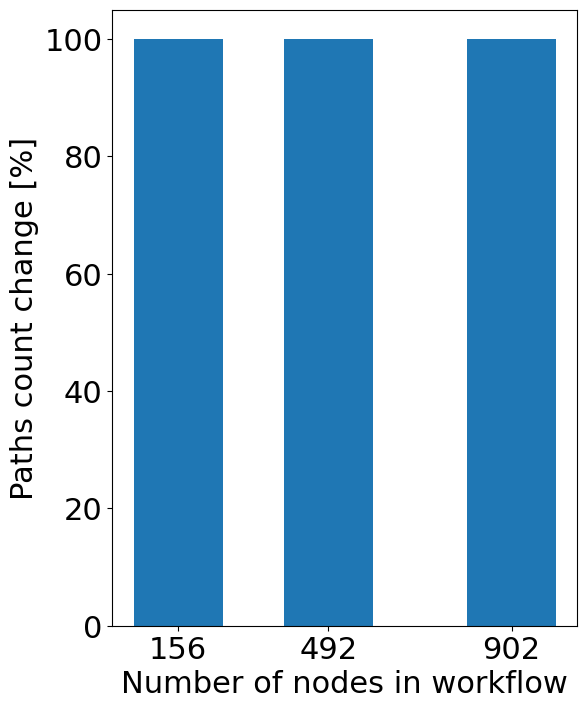

In [28]:
plot_ttsp_increase(pd.read_csv(csv_file), "1000genome", png_file)

## Montage

In [29]:
csv_file = os.path.join("problem_size_increase", "montage.csv")
png_file = os.path.join("problem_size_increase", "ttsp_path_increase_montage.png")

/tmp/ipykernel_57646/3746023734.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), fontsize=22)


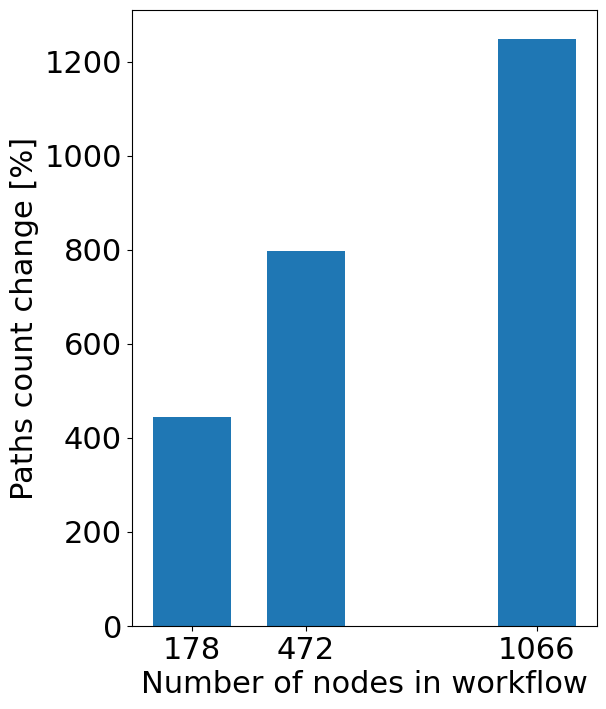

In [30]:
plot_ttsp_increase(pd.read_csv(csv_file), "Montage", png_file)

# Cycles

In [31]:
csv_file = os.path.join("problem_size_increase", "cycles.csv")
png_file = os.path.join("problem_size_increase", "ttsp_path_increase_cycles.png")

/tmp/ipykernel_57646/3746023734.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), fontsize=22)


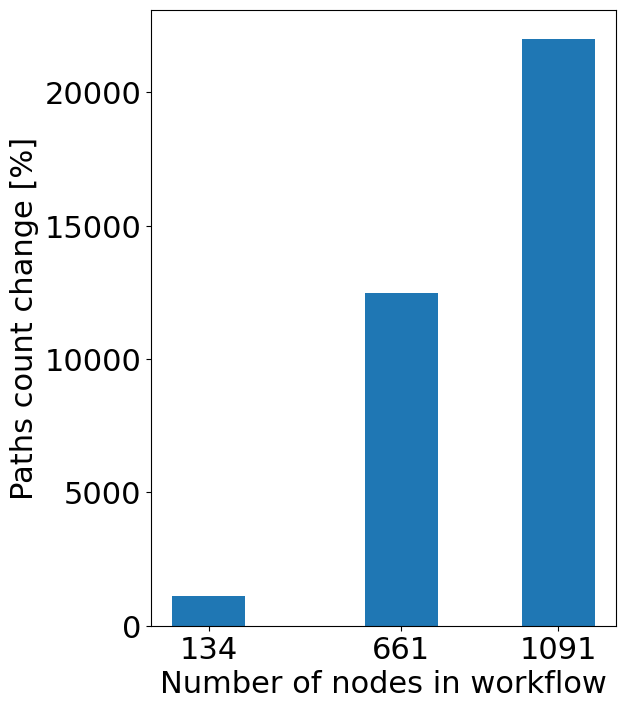

In [32]:
plot_ttsp_increase(pd.read_csv(csv_file), "cycles", png_file)

# Problem size without decomposition algorithm

In [2]:
def collect_problem_sizes(workflows_list: list[str], machines_file: str) -> pd.DataFrame:
    def measure_problem_size(workflow: Workflow) -> dict:
        print(f"Measuring workflow with {len(workflow.tasks)} nodes...")
        problem = WorkflowSchedulingOneHot(workflow)
        return {
            "workflow_size": len(workflow.tasks),
            "constraints": len(problem.constraints),
            "variables": len(problem.variables)
        }
    
    return pd.DataFrame([measure_problem_size(Workflow(task_file, machines_file, 100000)) for task_file in workflows_list])

In [3]:
machines_file = "../workflows_data/machines/linear_smaller_diff.json"

## 1000genome

In [211]:
workflows = [
    "/home/marcin/Programming/pegasus-instances/1000genome/chameleon-cloud/1000genome-chameleon-22ch-100k-001.json",
    "/home/marcin/Programming/pegasus-instances/1000genome/chameleon-cloud/1000genome-chameleon-20ch-250k-001.json",
    "/home/marcin/Programming/pegasus-instances/1000genome/chameleon-cloud/1000genome-chameleon-20ch-100k-001.json",
    "/home/marcin/Programming/pegasus-instances/1000genome/chameleon-cloud/1000genome-chameleon-22ch-250k-001.json",
    "/home/marcin/Programming/pegasus-instances/1000genome/chameleon-cloud/1000genome-chameleon-16ch-250k-001.json"
]

csv_file = os.path.join("problem_sizes", "ps_1000genome.csv")

In [212]:
collect_problem_sizes(workflows, machines_file).to_csv(csv_file)

## Cycles

In [215]:
workflows = [
  "/home/marcin/Programming/pegasus-instances/cycles/chameleon-cloud/cycles-chameleon-2l-2c-12p-001.json",
  "/home/marcin/Programming/pegasus-instances/cycles/chameleon-cloud/cycles-chameleon-5l-3c-9p-001.json",
  "/home/marcin/Programming/pegasus-instances/cycles/chameleon-cloud/cycles-chameleon-5l-1c-12p-001.json",
  "/home/marcin/Programming/pegasus-instances/cycles/chameleon-cloud/cycles-chameleon-10l-2c-12p-001.json",
  "/home/marcin/Programming/pegasus-instances/cycles/chameleon-cloud/cycles-chameleon-5l-2c-12p-001.json",
  "/home/marcin/Programming/pegasus-instances/cycles/chameleon-cloud/cycles-chameleon-5l-3c-12p-001.json",
  "/home/marcin/Programming/pegasus-instances/cycles/chameleon-cloud/cycles-chameleon-10l-3c-12p-001.json",
  "/home/marcin/Programming/pegasus-instances/cycles/chameleon-cloud/cycles-chameleon-10l-3c-9p-001.json",
  "/home/marcin/Programming/pegasus-instances/cycles/chameleon-cloud/cycles-chameleon-10l-2c-9p-001.json",
  "/home/marcin/Programming/pegasus-instances/cycles/chameleon-cloud/cycles-chameleon-1l-3c-12p-001.json"
]

csv_file = os.path.join("problem_sizes", "ps_cycles.csv")

In [216]:
collect_problem_sizes(workflows, machines_file).to_csv(csv_file)

## Epigenomics

In [217]:
workflows = [
  "/home/marcin/Programming/pegasus-instances/epigenomics/chameleon-cloud/epigenomics-chameleon-ilmn-6seq-50k-001.json",
  "/home/marcin/Programming/pegasus-instances/epigenomics/chameleon-cloud/epigenomics-chameleon-hep-7seq-50k-001.json",
  "/home/marcin/Programming/pegasus-instances/epigenomics/chameleon-cloud/epigenomics-chameleon-hep-6seq-50k-001.json",
  "/home/marcin/Programming/pegasus-instances/epigenomics/chameleon-cloud/epigenomics-chameleon-ilmn-3seq-50k-001.json",
  "/home/marcin/Programming/pegasus-instances/epigenomics/chameleon-cloud/epigenomics-chameleon-ilmn-6seq-100k-001.json",
  "/home/marcin/Programming/pegasus-instances/epigenomics/chameleon-cloud/epigenomics-chameleon-ilmn-5seq-50k-001.json"
]

csv_file = os.path.join("problem_sizes", "ps_epigenomics.csv")

In [218]:
collect_problem_sizes(workflows, machines_file).to_csv(csv_file)

## Seismology

In [219]:
workflows = [
  "/home/marcin/Programming/pegasus-instances/seismology/chameleon-cloud/seismology-chameleon-800p-001.json",
  "/home/marcin/Programming/pegasus-instances/seismology/chameleon-cloud/seismology-chameleon-700p-001.json",
  "/home/marcin/Programming/pegasus-instances/seismology/chameleon-cloud/seismology-chameleon-1000p-001.json",
  "/home/marcin/Programming/pegasus-instances/seismology/chameleon-cloud/seismology-chameleon-1100p-001.json",
  "/home/marcin/Programming/pegasus-instances/seismology/chameleon-cloud/seismology-chameleon-900p-001.json",
  "/home/marcin/Programming/pegasus-instances/seismology/chameleon-cloud/seismology-chameleon-600p-001.json"
]

csv_file = os.path.join("problem_sizes", "ps_seismology.csv")

In [220]:
collect_problem_sizes(workflows, machines_file).to_csv(csv_file)

## Soykb

In [221]:
workflows = [
  "/home/marcin/Programming/pegasus-instances/soykb/chameleon-cloud/soykb-chameleon-40fastq-20ch-001.json",
  "/home/marcin/Programming/pegasus-instances/soykb/chameleon-cloud/soykb-chameleon-50fastq-20ch-001.json",
  "/home/marcin/Programming/pegasus-instances/soykb/chameleon-cloud/soykb-chameleon-50fastq-10ch-001.json"
]

csv_file = os.path.join("problem_sizes", "ps_soykb.csv")

In [222]:
collect_problem_sizes(workflows, machines_file).to_csv(csv_file)

## SRA Search

In [223]:
workflows = [
  "/home/marcin/Programming/pegasus-instances/srasearch/chameleon-cloud/srasearch-chameleon-50a-001.json",
  "/home/marcin/Programming/pegasus-instances/srasearch/chameleon-cloud/srasearch-chameleon-30a-001.json",
  "/home/marcin/Programming/pegasus-instances/srasearch/chameleon-cloud/srasearch-chameleon-20a-001.json",
  "/home/marcin/Programming/pegasus-instances/srasearch/chameleon-cloud/srasearch-chameleon-40a-001.json",
  "/home/marcin/Programming/pegasus-instances/srasearch/chameleon-cloud/srasearch-chameleon-10a-001.json"
]

csv_file = os.path.join("problem_sizes", "ps_sra_search.csv")

In [224]:
collect_problem_sizes(workflows, machines_file).to_csv(csv_file)

## Montage

In [8]:
workflows = [
    "/home/marcin/Programming/pegasus-instances/montage/chameleon-cloud/montage-chameleon-dss-075d-001.json",
    "/home/marcin/Programming/pegasus-instances/montage/chameleon-cloud/montage-chameleon-2mass-015d-001.json",
    "/home/marcin/Programming/pegasus-instances/montage/chameleon-cloud/montage-chameleon-dss-10d-001.json",
    "/home/marcin/Programming/pegasus-instances/montage/chameleon-cloud/montage-chameleon-dss-125d-001.json",
    "/home/marcin/Programming/pegasus-instances/montage/chameleon-cloud/montage-chameleon-2mass-03d-001.json"
]

csv_file = os.path.join("problem_sizes", "ps_montage.csv")

In [9]:
collect_problem_sizes(workflows, machines_file).to_csv(csv_file)

Measuring workflow with 178 nodes...
Measuring workflow with 310 nodes...
Measuring workflow with 472 nodes...
Measuring workflow with 1066 nodes...
Measuring workflow with 748 nodes...


In [226]:
w = Workflow(
    "/home/marcin/Programming/pegasus-instances/montage/chameleon-cloud/montage-chameleon-2mass-04d-001.json",
    machines_file,
    1000000
)

In [227]:
p = WorkflowSchedulingOneHot(w)

In [228]:
print(f"number of nodes: {len(w.tasks)}, number of constraints: {len(p.constraints)}, number of variables: {len(p.variables)}")

number of nodes: 1312, number of constraints: 451312, number of variables: 6560


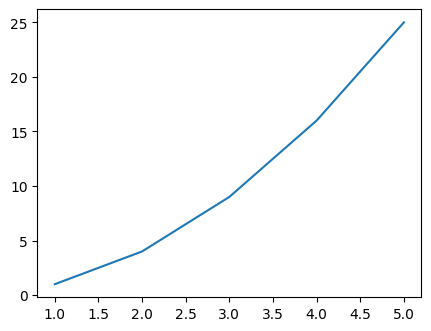

In [33]:
fig, ax = plt.subplots()

# Przykładowe dane
x = [1, 2, 3, 4, 5]
y = [1, 4, 9, 16, 25]

ax.plot(x, y)

# Ustawianie rozmiaru samego wykresu
left_margin = 0.2  # margines lewy
right_margin = 0.8  # margines prawy
bottom_margin = 0.2  # margines dolny
top_margin = 0.8  # margines górny

fig.subplots_adjust(left=left_margin, right=right_margin, bottom=bottom_margin, top=top_margin)

plt.show()